In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision as tv
import time

In [4]:
BATCH_SIZE = 256

transforms = tv.transforms.Compose([
    tv.transforms.Resize(32),
    tv.transforms.ToTensor()
])

In [5]:
train_dataset = tv.datasets.MNIST('.',
                                  train=True,
                                  transform=transforms,
                                  download=True)

test_dataset = tv.datasets.MNIST('.',
                                 train=False,
                                 transform=transforms,
                                 download=True)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
plt.imshow(train_dataset[0][0].numpy().reshape(32,32), cmap='gray');

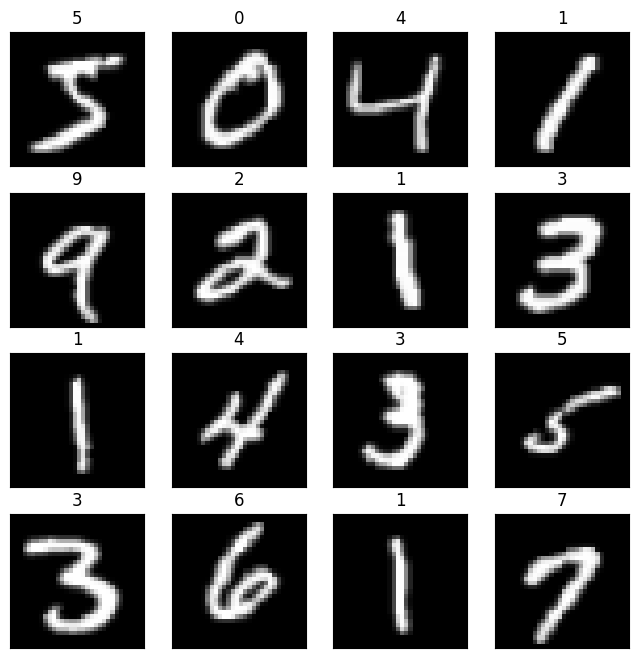

In [11]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_dataset[i][0].reshape(32,32), cmap='gray')
    plt.title(train_dataset[i][1])
plt.show()

In [14]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(16, 120, kernel_size=5),
    nn.Flatten(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
model = model.to(device)

In [17]:
def train(net, train_iter, test_iter, optimizer, num_epochs, device):
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net, device)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [18]:
def evaluate_accuracy(data_iter, net, device):
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [21]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0023, train acc 0.832, test acc 0.923, time 18.1 sec
epoch 2, loss 0.0009, train acc 0.935, test acc 0.954, time 12.3 sec
epoch 3, loss 0.0005, train acc 0.960, test acc 0.967, time 11.5 sec
epoch 4, loss 0.0004, train acc 0.972, test acc 0.974, time 11.4 sec
epoch 5, loss 0.0003, train acc 0.978, test acc 0.977, time 11.4 sec


In [ ]:
!pip install advertorch
import advertorch
from advertorch.attacks import LinfPGDAttack

#### Посмотрим примеры получаемых изображений с разным уровнем шума и измерим качество модели на них

In [74]:
epsilons = [0.03, 0.06, 0.09, 0.12, 0.15]


Epsilon = 0.03, Acuracy = 0.895


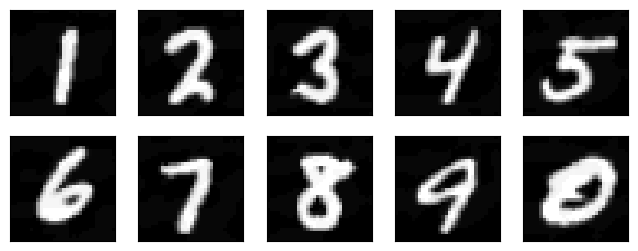

________________________________________________________________________________

Epsilon = 0.06, Acuracy = 0.573


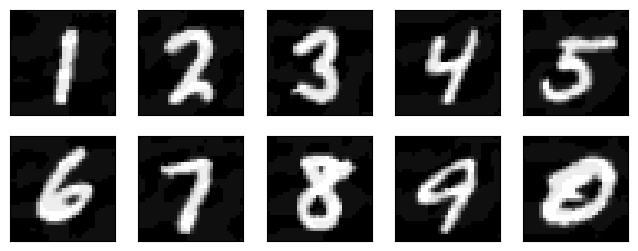

________________________________________________________________________________

Epsilon = 0.09, Acuracy = 0.276


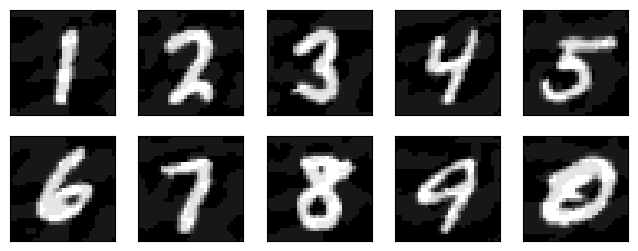

________________________________________________________________________________

Epsilon = 0.12, Acuracy = 0.112


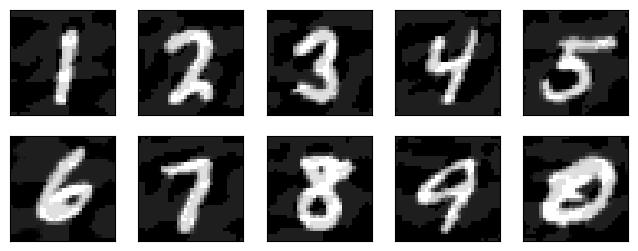

________________________________________________________________________________

Epsilon = 0.15, Acuracy = 0.046


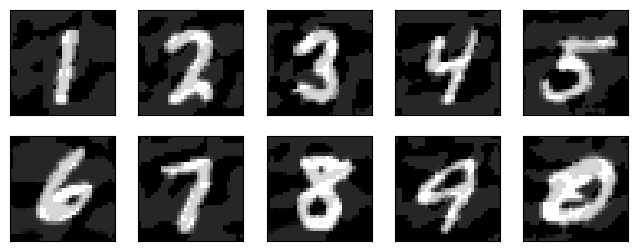

________________________________________________________________________________


In [78]:
for eps in epsilons:
    adversary = LinfPGDAttack(model, eps=eps)
    test_acc_sum, n = 0.0, 0
    model.eval()
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        adv_images = adversary.perturb(X, y)
        y_hat = model(adv_images)
        test_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
        n += y.shape[0]
        test_acc = test_acc_sum / n
    print()
    print(f'Epsilon = {eps}, Acuracy = {test_acc:.3f}')

    plt.figure(figsize=(8, 3))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        adv_images = adv_images.to('cpu')
        plt.imshow(adv_images[i].reshape(32,32), cmap='gray')
    plt.show();
    print('_' * 80)

### Шум в изображениях не так критичен для человеческого глаза и не мешает классификации цифр, но, как видим, сильно затрудняет работу модели